# Project 3, Milestone 5:
# Twitter Analysis & Identification of Salient Topics During the Fall 2019 Protests in Chile

Shreya Parjan

12/20/19

This upper-level project was completed for Professor Eni Mustafaraj's Fall 2019 CS 234: Data, Analytics, and Visualization course at Wellesley College. The objective of the project is to examine tweets from the accounts of leftist politicians, artists, activists, academics, and journalists in Chile over the course of the 2019 Chilean protests in response to growing inequality and corruption in the country. Through this analysis, we'll better understand what groups among these leftist users are most active, what key hashtags have been used over time to support conversation about the uprisings, and how users' tweets can identify key topics in the protests.

**Key Question**: What topics are relevant to liberals during the protests in Chile? (How) have these topics evolved?


The following table of contents directly corresponds with requirements for A-level work on this project:

**Table of Contents**
0. [Data Pre-processing](#sec0)
1. [Featurization](#sec1)
    - [Visualization 1: Frequency of tweets over time](#sec1-1)
    - [Visualization 2: Identification of most active community members](#sec1-2)
    - [Visualization 3: Hashtag trends over time](#sec1-3)
2. [Hypothesis Test: Gender & Sentiment Analysis](#sec2)
3. [Modeling: LDA Topic Modeling](#sec3)
    - [Visualization 4: Topic Analysis Heatmap](#sec3-1)
    - [Visualization 5: Topic Analysis](#sec3-2)
4. [Reflection](#sec4)

## 0) Data Pre-Processing
<a id="sec0"></a>

Since I had worked extensively with JSON files in the earlier milestones and because I wanted to collect more tweets to span the entirety of the crisis thus far, I thought now would be a good time to use the GetOldTweets library.

**NOTE:** This code takes a long time to run because it involved 40 calls to "GetOldTweets". You are recommended to skip directly to Step 1 which works with the CSV that this step outputs to.

In [2]:
import json
import pandas as pd
import GetOldTweets3 as got

In [ ]:
acctList = ['ClaudiaDides','Pa__tty','ValdebenitoNata','tv_monica','KarolCariola','gabrielboric','BeaSanchezYTu','LorenaPizarroS','GiorgioJackson',
           'camila_vallejo','Claudia_Mix','JorgeSharp','carmen_hertz','redolesoficial',
           'manugarpez','nanostern','jcoulon','labeasanchez','FelipeParadaM',
           'AlbertoMayol','PamJiles','DMatamala','CristobalYessen','danieljadue',
           'sarmiento510','IraciHassler','nataliacuevasg','mriesco','MauroMura11',
           'juan_urra','tomashirsch','monlaferte','emiliatijoux','MarianaLaActriz',
           'Jaime_Bassa','KenaLorenziniL','mirnaschindler','ale_injoque','mauricio_weibel','JParadaHoyl']


I chose to extract tweets from October 14-December 10 2019: when the government first started recognizing the impact of the protests and closing train stations in response up to the date I started working on this project.

In [ ]:
"""getTweets returns all tweets from the user accounts"""
def getTweets(users):
    usertweets = []
    for i in users:
        tweetCriteria = got.manager.TweetCriteria().setUsername(i)\
                                                   .setSince("2019-10-14")\
                                                   .setUntil("2019-12-10") #this date range captures the start of the protests to present day
        tweet = got.manager.TweetManager.getTweets(tweetCriteria)
        usertweets.append(tweet)
    return usertweets

In [ ]:
usertweets = getTweets(acctList)

In [ ]:
len(usertweets)

Now, I can directly access features of interest and create a dataframe that contains all of them.

In [ ]:
usernames = []
dates = []
texts = []
hashtagss = []
tos = []
repliess = []
retweetss = []
favoritess = []
mentionss = []

"""get old tweets is really well organized, so now all I have to do is access the feature of desire from the data"""
for i in range(len(usertweets)):
    for j in range(len(usertweets[i])):
        usernames.append(usertweets[i][j].username)
        dates.append(usertweets[i][j].date)
        tos.append(usertweets[i][j].to)
        repliess.append(usertweets[i][j].replies)
        retweetss.append(usertweets[i][j].retweets)
        favoritess.append(usertweets[i][j].favorites)
        texts.append(usertweets[i][j].text)
        mentionss.append(usertweets[i][j].mentions)
        hashtagss.append(usertweets[i][j].hashtags)

In [ ]:
df = pd.DataFrame({'username': usernames,'date':dates, 'text':texts,
                   'hashtags':hashtagss,'to':tos,'replies':repliess,
                  'retweets':retweetss,'favorites':favoritess,'mentions':mentionss}) #this dataframe compiles all the features of interest across uers


In [ ]:
df.head()

If rerunning this code, skip this step to save time. We load the CSV generated below in step 1.

In [ ]:
"""converting the dataframe to csv prevents me from having to rerun the above code"""
df.to_csv("tweetbase.csv")

## 1) Featurization
<a id="sec1"></a>

In [56]:
df = pd.read_csv("tweetbase.csv") 
df= df.drop(columns=['Unnamed: 0'])

Out of curiosity/to take a quick look at engagements across all forms of interacting with tweets, I created a totalEngagement feature that combines replies, retweets, and favorites.

In [57]:
df['totalEngagement'] = df['replies']+df['retweets']+df['favorites']

In [58]:
df.head()

,username,date,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement
0,ClaudiaDides,2019-12-09 23:32:47+00:00,Ahora en el campamento de la dignidad por una ...,#AsambleaConstituyente,NaN,6,31,119,NaN,156
1,ClaudiaDides,2019-12-09 17:16:29+00:00,"Muy enredada, nadie sabe donde ir a votar @ACh...",NaN,CristobalRec,0,1,1,@AChMChile,2
2,ClaudiaDides,2019-12-09 13:11:11+00:00,"Este fin de semana es la Cobsulta Municipal, q...",#AsambleaConstituyente #NuevaConstituci,NaN,2,22,20,NaN,44
3,ClaudiaDides,2019-12-09 12:41:38+00:00,Para las feministas nuestro enemigo es el orde...,NaN,SylviaEyzaguirr,1,4,17,NaN,22
4,ClaudiaDides,2019-12-09 05:11:34+00:00,,NaN,marcelamaliki,0,0,3,NaN,3


After identifying the genders of all my profiles, I decided it would be helpful for potential gender related analyses to make a new feature for it.

In [59]:
femlist = ['ClaudiaDides','Pa__tty','ValdebenitoNata','tv_monica',
           'KarolCariola','BeaSanchezYTu','LorenaPizarroS','camila_vallejo',
           'Claudia_Mix','carmen_hertz','','labeasanchez','PamJiles',
           'IraciHassler','nataliacuevasg','monlaferte','emiliatijoux',
           'MarianaLaActriz','KenaLorenziniL','mirnaschindler','ale_injoque']
           
malelist = ['gabrielboric','JorgeSharp','GiorgioJackson','redolesoficial',
            'manugarpez','nanostern','jcoulon','FelipeParadaM',
            'AlbertoMayol','DMatamala','CristobalYessen','danieljadue',
            'sarmiento510','mriesco','MauroMura11','juan_urra',
            'tomashirsch','Jaime_Bassa','mauricio_weibel','JParadaHoyl']

genlist = []         
for i in range(len(df)):
    if df['username'][i] in femlist:
        genlist.append('f')
    if df['username'][i] in malelist:
        genlist.append('m')

In [60]:
df['gender'] = genlist

In [61]:
df.head()

,username,date,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement,gender
0,ClaudiaDides,2019-12-09 23:32:47+00:00,Ahora en el campamento de la dignidad por una ...,#AsambleaConstituyente,NaN,6,31,119,NaN,156,f
1,ClaudiaDides,2019-12-09 17:16:29+00:00,"Muy enredada, nadie sabe donde ir a votar @ACh...",NaN,CristobalRec,0,1,1,@AChMChile,2,f
2,ClaudiaDides,2019-12-09 13:11:11+00:00,"Este fin de semana es la Cobsulta Municipal, q...",#AsambleaConstituyente #NuevaConstituci,NaN,2,22,20,NaN,44,f
3,ClaudiaDides,2019-12-09 12:41:38+00:00,Para las feministas nuestro enemigo es el orde...,NaN,SylviaEyzaguirr,1,4,17,NaN,22,f
4,ClaudiaDides,2019-12-09 05:11:34+00:00,,NaN,marcelamaliki,0,0,3,NaN,3,f


In [62]:
dfdate = df.groupby('date') 

In [63]:
dfd = dfdate.first()

In [64]:
dfd.head()

,username,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement,gender
date,,,,,,,,,,
2019-10-14 00:01:01+00:00,KenaLorenziniL,así es....,NaN,absurdidez,0,0,0,NaN,0,f
2019-10-14 00:06:53+00:00,labeasanchez,#RodrigoMundaca es un incansable luchador del ...,#RodrigoMundaca #MundacaNoEst,NaN,11,127,269,@SColectivos,407,f
2019-10-14 00:06:57+00:00,KenaLorenziniL,Dale Curicana!!,NaN,EveFitCL,0,0,3,NaN,3,f
2019-10-14 00:07:47+00:00,KenaLorenziniL,y tú eres lesbiana?...qué asco,NaN,ErikaMontecinos,1,0,2,NaN,3,f
2019-10-14 00:12:09+00:00,KenaLorenziniL,LISTOCO TELLIER CERRÓ LA PUERTA AL ÚNICO ESPAC...,NaN,ElMercurio_cl,24,6,19,NaN,49,f


In [65]:
dfdatesort = dfd.reset_index()

dfdatesort has all the tweets sorted by date they were posted

In [66]:
dfdatesort.head()

,date,username,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement,gender
0,2019-10-14 00:01:01+00:00,KenaLorenziniL,así es....,NaN,absurdidez,0,0,0,NaN,0,f
1,2019-10-14 00:06:53+00:00,labeasanchez,#RodrigoMundaca es un incansable luchador del ...,#RodrigoMundaca #MundacaNoEst,NaN,11,127,269,@SColectivos,407,f
2,2019-10-14 00:06:57+00:00,KenaLorenziniL,Dale Curicana!!,NaN,EveFitCL,0,0,3,NaN,3,f
3,2019-10-14 00:07:47+00:00,KenaLorenziniL,y tú eres lesbiana?...qué asco,NaN,ErikaMontecinos,1,0,2,NaN,3,f
4,2019-10-14 00:12:09+00:00,KenaLorenziniL,LISTOCO TELLIER CERRÓ LA PUERTA AL ÚNICO ESPAC...,NaN,ElMercurio_cl,24,6,19,NaN,49,f


### Exploratory Visualization 1: Frequency of tweets over time
<a id="sec1-1"></a>
The objective of this visualization step is to take a big picture look at how often my leftist accounts used Twitter over the course of the crisis thus far.

In [67]:
uniquedates = []
for d in dfdatesort['date']:
    if d[0:10] not in uniquedates:
        uniquedates.append(d[0:10])

In [68]:
uniquedatect = [0]*len(uniquedates)
for date in range(len(uniquedates)):
    for d in dfdatesort['date']:
        if d[0:10] == uniquedates[date]:
            uniquedatect[date]+=1

In [69]:
import plotly.express as px

In [70]:
dfdate = pd.DataFrame({'date': uniquedates,'count':uniquedatect})

In [163]:
fig = px.line(dfdate, x='date', y='count')
fig.update_layout(
    title={
        'text': "Tweet Count over Time",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

**Figure 1. Tweet Count over Time:** This plot shows how many tweets were made over all accounts over the entire window of collected data. As corroborated by news articles/updates on the situation, the window from October 20-27 coincides with a rise of protests while November 15 follows an announcement that the government will reform the constitution.

### Exploratory Visualization 2: Identification of most active community members
<a id="sec1-2"></a>
Next, I thought it'd be interesting to trace degree of activity across all types of accounts that I was following

In [72]:
"""i had preclassified each account"""
glist = ['JParadaHoyl','tomashirsch','sarmiento510','danieljadue','PamJiles','labeasanchez','JorgeSharp','Claudia_Mix','camila_vallejo','GiorgioJackson','BeaSanchezYTu','gabrielboric','KarolCariola','carmen_hertz']
alist = ['Pa__tty','ale_injoque','KenaLorenziniL','juan_urra','nataliacuevasg','IraciHassler','CristobalYessen','AlbertoMayol','FelipeParadaM','LorenaPizarroS']
jlist = ['mauricio_weibel','mirnaschindler','DMatamala','tv_monica']
plist = ['Jaime_Bassa','ClaudiaDides','emiliatijoux','MauroMura11','mriesco']
tlist = ['MarianaLaActriz','monlaferte','jcoulon','nanostern','manugarpez','redolesoficial','ValdebenitoNata']

joblist = []
for i in range(len(dfdatesort)):
    if dfdatesort['username'][i] in glist:
        joblist.append('politician')
    elif dfdatesort['username'][i] in alist:
        joblist.append('activist')
    elif dfdatesort['username'][i] in jlist:
        joblist.append('journalist')
    elif dfdatesort['username'][i] in plist:
        joblist.append('academic')
    elif dfdatesort['username'][i] in tlist:
        joblist.append('artist')
        
dfdatesort['profession'] = joblist

In [73]:
dfdatesort.head()

,date,username,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement,gender,profession
0,2019-10-14 00:01:01+00:00,KenaLorenziniL,así es....,NaN,absurdidez,0,0,0,NaN,0,f,activist
1,2019-10-14 00:06:53+00:00,labeasanchez,#RodrigoMundaca es un incansable luchador del ...,#RodrigoMundaca #MundacaNoEst,NaN,11,127,269,@SColectivos,407,f,politician
2,2019-10-14 00:06:57+00:00,KenaLorenziniL,Dale Curicana!!,NaN,EveFitCL,0,0,3,NaN,3,f,activist
3,2019-10-14 00:07:47+00:00,KenaLorenziniL,y tú eres lesbiana?...qué asco,NaN,ErikaMontecinos,1,0,2,NaN,3,f,activist
4,2019-10-14 00:12:09+00:00,KenaLorenziniL,LISTOCO TELLIER CERRÓ LA PUERTA AL ÚNICO ESPAC...,NaN,ElMercurio_cl,24,6,19,NaN,49,f,activist


In [74]:
uniqueprofs = ['politician','activist','journalist','academic','artist']
oprofct = [0]*len(uniqueprofs)
nprofct = [0]*len(uniqueprofs)
dprofct = [0]*len(uniqueprofs)
for row in range(len(dfdatesort)):
    if dfdatesort['date'][row][:7] == "2019-10":
        profstr = dfdatesort['profession'][row]
        oprofct[uniqueprofs.index(profstr)]+=1
    if dfdatesort['date'][row][:7] == "2019-11":
        profstr = dfdatesort['profession'][row]
        nprofct[uniqueprofs.index(profstr)]+=1
    if dfdatesort['date'][row][:7] == "2019-12":
        profstr = dfdatesort['profession'][row]
        dprofct[uniqueprofs.index(profstr)]+=1

In [75]:
dfvis2 = pd.DataFrame({'profession': uniqueprofs,'october':oprofct, 'november':nprofct,'december':dprofct})
dfvis2

,profession,october,november,december
0,politician,1540,1976,397
1,activist,2887,4589,1309
2,journalist,974,793,156
3,academic,1075,2408,772
4,artist,2565,1904,394


In [165]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure(data=[go.Bar(x=uniqueprofs,y=oprofct,name='October'),
                      go.Bar(x=uniqueprofs,y=nprofct,name='November'),
                      go.Bar(x=uniqueprofs,y=dprofct,name='December')])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.update_layout(
    title={
        'text': "Twitter Activity by Profession",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

**Figure 2. Tweet Activity by Profession:** This plot shows the distribution of tweets made by each account by each month. As expected, the leftist activists are the most vocal on the platform. It's important to point out that my choice of accounts relied heavily on following people recommended to me by Twitter, so the distribution of each profession isn't entirely even. However, I'm following teh most politicians so it's interesting that they aren't leading the charge on Twitter and even though I'm following close to the same number of artists and journalists, artists have more clearly engaged with the platform.

### Exploratory Visualization 3: Hashtag trends over time
<a id="sec1-3"></a>
This component is focused on creating a tool that can be used to output a graph of hashtag use over time for any hashtag of interest with this data.

In [77]:
from collections import Counter

Extracting all hashtags in the data (repeats allowed)

In [78]:
alltags = []
for row in range(len(dfdatesort)):
    if type(dfdatesort['hashtags'][row]) == str:
        for i in dfdatesort['hashtags'][row].split(" "):
            alltags.append(i.lower())

From alltags, creating a counter dictionary to identify the most popular tags

In [79]:
uniquetags = Counter()
for tag in alltags:
    uniquetags[tag] += 1
toplist = uniquetags.most_common()[0:10]

In [80]:
toplist

[('#chile', 284),
 ('#pi', 170),
 ('#acusacionconstitucionalapi', 125),
 ('#asambleaconstituyente', 123),
 ('#estopasaenchile', 113),
 ('#estonohaterminado', 96),
 ('#chiledesperto', 95),
 ('#nuevaconstitucion', 94),
 ('#chiledespert', 89),
 ('#renunciapi', 87)]

In [81]:
dfdatesort.head()

,date,username,text,hashtags,to,replies,retweets,favorites,mentions,totalEngagement,gender,profession
0,2019-10-14 00:01:01+00:00,KenaLorenziniL,así es....,NaN,absurdidez,0,0,0,NaN,0,f,activist
1,2019-10-14 00:06:53+00:00,labeasanchez,#RodrigoMundaca es un incansable luchador del ...,#RodrigoMundaca #MundacaNoEst,NaN,11,127,269,@SColectivos,407,f,politician
2,2019-10-14 00:06:57+00:00,KenaLorenziniL,Dale Curicana!!,NaN,EveFitCL,0,0,3,NaN,3,f,activist
3,2019-10-14 00:07:47+00:00,KenaLorenziniL,y tú eres lesbiana?...qué asco,NaN,ErikaMontecinos,1,0,2,NaN,3,f,activist
4,2019-10-14 00:12:09+00:00,KenaLorenziniL,LISTOCO TELLIER CERRÓ LA PUERTA AL ÚNICO ESPAC...,NaN,ElMercurio_cl,24,6,19,NaN,49,f,activist


This was a difficult function to write because it involved a lot of thinking about how components of the dataframe interact with each other. Ultimately, tagdistrib takes in a hashtag of interest and outputs a dataframe of the frequency of that tag on each of the unique dates in dfdatesort

In [82]:
def tagdistrib(tag):
    tagdates = [0]*len(uniquedates) #count list same length as number of unique dates
    for d in range(len(uniquedates)):
        for index,row in dfdatesort.iterrows():
            if row['date'][0:10] == uniquedates[d]: #take substring to ignore additional granularity like time on a given day
                if type(row['hashtags']) == str:
                    taglist = row['hashtags'].split(" ") #access the hashtags for non-nan values
                    for i in taglist:
                        if tag == i.lower(): #lowercase to avoid duplicates
                            tagdates[uniquedates.index(uniquedates[d])]+=1
    df = pd.DataFrame({'date': uniquedates,'frequency':tagdates})
    return df

In [167]:
fig = px.line(tagdistrib('#chile'), x='date', y='frequency')
fig.update_layout(
    title={
        'text': "Frequency of '#chile' over dataset",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

**Figure 3a. Frequency of '#chile' over dataset** Across the window of time spanned by the dataset, this tracks the popularity of #chile among my users. As expected, it's relatively popular over the entire window since all of the users are Chilean.

In [169]:
fig1 = px.line(tagdistrib('#chiledesperto'), x='date', y='frequency')

In [171]:
fig1.update_layout(
    title={
        'text': "Frequency of '#chiledesperto' over dataset",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig1.show()

**Figure 3b. Frequency of '#chiledesperto' over dataset** This hashtag means "awaken Chile" in English. It's a call to action that as we can see was more popular among my accounts at the beginning of the protests.

In [172]:
fig2 = px.line(tagdistrib('#renunciapi'), x='date', y='frequency')
fig2.update_layout(
    title={
        'text': "Frequency of '#renunciapi' over dataset",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig2.show()

**Figure 3c. Frequency of '#renunciapi' over dataset** This hashtag is a call to renounce the current Chlean president, Sebastián Piñera. The drop off for this hashtag is especially intense and makes me wonder if there are any external users suppressing expression of anti-government views or if this really does suggest a transition in the movement away from attacks on the president.

## 2) Hypothesis Test: Gender & Sentiment Analysis
<a id="sec2"></a>

**Hypothesis:** Women's tweets are more positive than Men's. Our null hypothesis is that there is no difference in sentiment between women's and men's tweets. I tried several packages before implementing the classifier senti-py https://github.com/aylliote/senti-py.

In [86]:
from classifier import *
clf = SentimentClassifier()

Create the body of all tweets and separate into male or female based on earlier gender classification.

In [87]:
corpus=[]
a=[]
for i in range(len(dfdatesort['text'])):
        a=dfdatesort['text'][i]
        corpus.append(a)

In [88]:
femtweets = []
maltweets = []
for row in range(len(dfdatesort)):
    if dfdatesort['gender'][row] == 'f':
        femtweets.append(dfdatesort['text'][row])
    else:
        maltweets.append(dfdatesort['text'][row])

In [107]:
import random
from random import sample 

**Two-step t test**

We begin with a sample a bit larger than 10% of the data. I attempted to seed it so we could have replicable results when investigating whether men or women have more negative tweets. The steps beneath follow from work like that in A7.

In [148]:
random.seed()
femsample = sample(femtweets,2000)
malsample = sample(maltweets,2000)

In [149]:
femsent = []
malsent = []
for i in range(len(femsample)):
    femsent.append(clf.predict(str(femsample[i])))
    malsent.append(clf.predict(str(malsample[i])))

In [150]:
from pandas import Series

femseries = Series(femsent)
femseries.describe()

count    2000.000000
mean        0.307374
std         0.265827
min         0.000109
25%         0.058531
50%         0.241604
75%         0.541333
max         0.995198
dtype: float64

In [151]:
malseries = Series(malsent)
malseries.describe()

count    2000.000000
mean        0.266438
std         0.265557
min         0.000025
25%         0.030785
50%         0.167606
75%         0.489547
max         0.997203
dtype: float64

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([651., 256., 195., 152., 130., 331., 112.,  63.,  54.,  56.]),
 array([1.08842050e-04, 9.96177840e-02, 1.99126726e-01, 2.98635668e-01,
        3.98144610e-01, 4.97653552e-01, 5.97162494e-01, 6.96671435e-01,
        7.96180377e-01, 8.95689319e-01, 9.95198261e-01]),
 <a list of 10 Patch objects>)

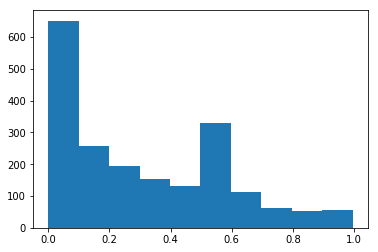

In [153]:
plt.hist(femseries)

(array([833., 229., 183., 132., 141., 219., 104.,  64.,  53.,  42.]),
 array([2.52384997e-05, 9.97429836e-02, 1.99460729e-01, 2.99178474e-01,
        3.98896219e-01, 4.98613964e-01, 5.98331709e-01, 6.98049454e-01,
        7.97767199e-01, 8.97484945e-01, 9.97202690e-01]),
 <a list of 10 Patch objects>)

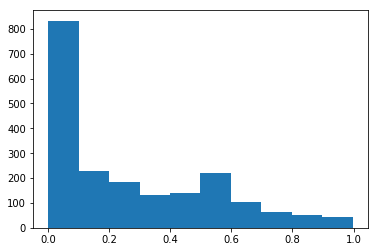

In [154]:
plt.hist(malseries)

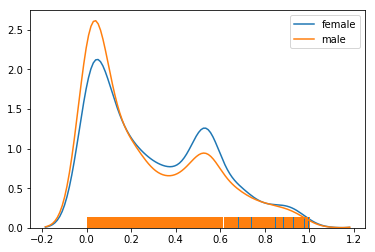

In [155]:
import seaborn as sns

sns.distplot(femseries, hist=False, rug=True, label='female')
sns.distplot(malseries, hist=False, rug=True, label='male')

This chart suggests that both men and women have bimodal distributions of whether their tweets are more positive or negative. But ultimately, more of the data for men is clustered in the negative sentiment area than that for women.

In [156]:
import scipy.stats as stats

In [157]:
twoSampleTest = stats.ttest_ind(femseries, malseries, 
                equal_var=False) # don't assume that variance is the same

twoSampleTest

Ttest_indResult(statistic=4.872226811345032, pvalue=1.1462268380464232e-06)

In [158]:
from plotly.figure_factory import create_table
matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', twoSampleTest[0], twoSampleTest[1]/2]
]

test_table = create_table(matrix_twosample, index=True)
test_table.show()

Because t > 2 and p < 0.05, we reject H0 and conclude that there is a significant relationship between gender and sentiment of tweets. Our visualizations above further support our alternate hypothesis that women's tweets are less negative than men's.

## 3) Modeling: LDA Topic Modelling
<a id="sec3"></a>

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

Resource: https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets

Honestly, the hardest part of all this was just importing all of the necessary packages.

In [31]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import pyLDAvis.gensim

In [32]:
init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [33]:
corpus=[]
a=[]
for i in range(len(dfdatesort['text'])):
        a=dfdatesort['text'][i]
        corpus.append(a)

In [34]:
import os

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/var/folders/4g/l5vtg9556fs0kxjbmxybn5100000gn/T" will be used to save temporary dictionary and corpus.


In [35]:
# removing common words and tokenizing
list1 = ['RT','rt']
import nltk
nltk.download('stopwords')
stoplist = stopwords.words('spanish') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'lda.dict'))  # store the dictionary, for future reference

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sparjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2019-12-13 18:27:41,311 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-12-13 18:27:41,534 : INFO : adding document #10000 to Dictionary(28149 unique tokens: ['así', 'es....', '#mundacanoestásolo', '#rodrigomundaca', '@scolectivos']...)
2019-12-13 18:27:41,751 : INFO : adding document #20000 to Dictionary(45335 unique tokens: ['así', 'es....', '#mundacanoestásolo', '#rodrigomundaca', '@scolectivos']...)
2019-12-13 18:27:41,827 : INFO : built Dictionary(50717 unique tokens: ['así', 'es....', '#mundacanoestásolo', '#rodrigomundaca', '@scolectivos']...) from 23739 documents (total 238259 corpus positions)
2019-12-13 18:27:41,828 : INFO : saving Dictionary object under /var/folders/4g/l5vtg9556fs0kxjbmxybn5100000gn/T/lda.dict, separately None
2019-12-13 18:27:41,859 : INFO : saved /var/folders/4g/l5vtg9556fs0kxjbmxybn5100000gn/T/lda.dict


In [36]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'lda.mm'), corpus)

2019-12-13 18:27:42,121 : INFO : storing corpus in Matrix Market format to /var/folders/4g/l5vtg9556fs0kxjbmxybn5100000gn/T/lda.mm
2019-12-13 18:27:42,124 : INFO : saving sparse matrix to /var/folders/4g/l5vtg9556fs0kxjbmxybn5100000gn/T/lda.mm
2019-12-13 18:27:42,125 : INFO : PROGRESS: saving document #0
2019-12-13 18:27:42,148 : INFO : PROGRESS: saving document #1000
2019-12-13 18:27:42,175 : INFO : PROGRESS: saving document #2000
2019-12-13 18:27:42,196 : INFO : PROGRESS: saving document #3000
2019-12-13 18:27:42,222 : INFO : PROGRESS: saving document #4000
2019-12-13 18:27:42,243 : INFO : PROGRESS: saving document #5000
2019-12-13 18:27:42,268 : INFO : PROGRESS: saving document #6000
2019-12-13 18:27:42,285 : INFO : PROGRESS: saving document #7000
2019-12-13 18:27:42,314 : INFO : PROGRESS: saving document #8000
2019-12-13 18:27:42,338 : INFO : PROGRESS: saving document #9000
2019-12-13 18:27:42,360 : INFO : PROGRESS: saving document #10000
2019-12-13 18:27:42,384 : INFO : PROGRESS: 

In [37]:
tfidf = models.TfidfModel(corpus) #implement model

2019-12-13 18:27:43,957 : INFO : collecting document frequencies
2019-12-13 18:27:43,959 : INFO : PROGRESS: processing document #0
2019-12-13 18:27:43,992 : INFO : PROGRESS: processing document #10000
2019-12-13 18:27:44,023 : INFO : PROGRESS: processing document #20000
2019-12-13 18:27:44,039 : INFO : calculating IDF weights for 23739 documents and 50717 features (232739 matrix non-zeros)


In [38]:
corpus_tfidf = tfidf[corpus]

In [47]:
total_topics = 4 #found using some trial and error on different values

Oh for sure, we need more sustainable math and statistics classes to un

In [48]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

2019-12-13 18:30:20,886 : INFO : using symmetric alpha at 0.25
2019-12-13 18:30:20,887 : INFO : using symmetric eta at 0.25
2019-12-13 18:30:20,896 : INFO : using serial LDA version on this node
2019-12-13 18:30:20,917 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 23739 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-12-13 18:30:20,921 : INFO : PROGRESS: pass 0, at document #2000/23739
2019-12-13 18:30:21,777 : INFO : merging changes from 2000 documents into a model of 23739 documents
2019-12-13 18:30:21,786 : INFO : topic #0 (0.250): 0.006*"así" + 0.005*"solo" + 0.004*"q" + 0.003*"pueblo" + 0.003*"gobierno" + 0.003*"gracias" + 0.003*"violencia" + 0.003*"si" + 0.002*"#desobedienciacivil" + 0.002*"país"
2019-12-13 18:30:21,788 : INFO : topic #1 (0.250): 0.009*"q" + 0.006*"gobierno" + 0.004*"si" + 0.003*"d" + 0.002*"chile" + 0.

2019-12-13 18:30:26,011 : INFO : topic #1 (0.250): 0.009*"q" + 0.007*"acuerdo" + 0.005*"gobierno" + 0.004*"si" + 0.004*"plebiscito" + 0.003*"chile" + 0.003*"mismo" + 0.003*"ser" + 0.003*"#asambleaconstituyente" + 0.002*"hoy"
2019-12-13 18:30:26,013 : INFO : topic #2 (0.250): 0.026*"q" + 0.004*"x" + 0.004*"si" + 0.004*"hoy" + 0.004*"solo" + 0.003*"parte" + 0.003*"d" + 0.003*"gente" + 0.003*"mecanismo" + 0.003*"nueva"
2019-12-13 18:30:26,014 : INFO : topic #3 (0.250): 0.014*"si" + 0.008*"constitución" + 0.006*"q" + 0.006*"derechos" + 0.005*"ser" + 0.004*"nueva" + 0.004*"nan" + 0.004*"violaciones" + 0.004*"debe" + 0.004*"d"
2019-12-13 18:30:26,015 : INFO : topic diff=0.427954, rho=0.353553
2019-12-13 18:30:26,017 : INFO : PROGRESS: pass 0, at document #18000/23739
2019-12-13 18:30:26,493 : INFO : merging changes from 2000 documents into a model of 23739 documents
2019-12-13 18:30:26,502 : INFO : topic #0 (0.250): 0.011*"gracias" + 0.005*"pueblo" + 0.004*"así" + 0.004*"chile" + 0.004*"solo

We set the ideal number of contents to group data into based on what level of party people usually have.

In [49]:
lda.show_topics(total_topics,5)

[(0,
  '0.012*"gracias" + 0.004*"dignidad" + 0.004*"así" + 0.003*"pueblo" + 0.003*"chile"'),
 (1,
  '0.006*"q" + 0.005*"acuerdo" + 0.004*"gobierno" + 0.003*"si" + 0.003*"hoy"'),
 (2, '0.024*"q" + 0.004*"x" + 0.004*"d" + 0.004*"hoy" + 0.004*"solo"'),
 (3,
  '0.011*"si" + 0.008*"derechos" + 0.006*"violaciones" + 0.005*"ser" + 0.005*"q"')]

In [50]:

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}


In [51]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(4, 75)


In [52]:
df_lda

,@cidh,@cooperativa,abrazo,acuerdo,acusación,ahora,así,bot,buena,cada,...,tan,todas,va,vida,violaciones,violador,violencia,voy,vía,x
0,0.00263,0.000000,0.000000,0.000000,0.000000,0.000000,0.003603,0.001806,0.001981,0.001774,...,0.002383,0.000000,0.000000,0.002082,0.000000,0.000000,0.002125,0.00000,0.002163,0.000000
1,0.00000,0.001735,0.001746,0.005198,0.001968,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002289,0.000000,0.00178,0.002099,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.001951,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001784,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.004153
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.002073,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002065,0.000000,0.000000,0.005995,0.000000,0.002272,0.00000,0.000000,0.000000


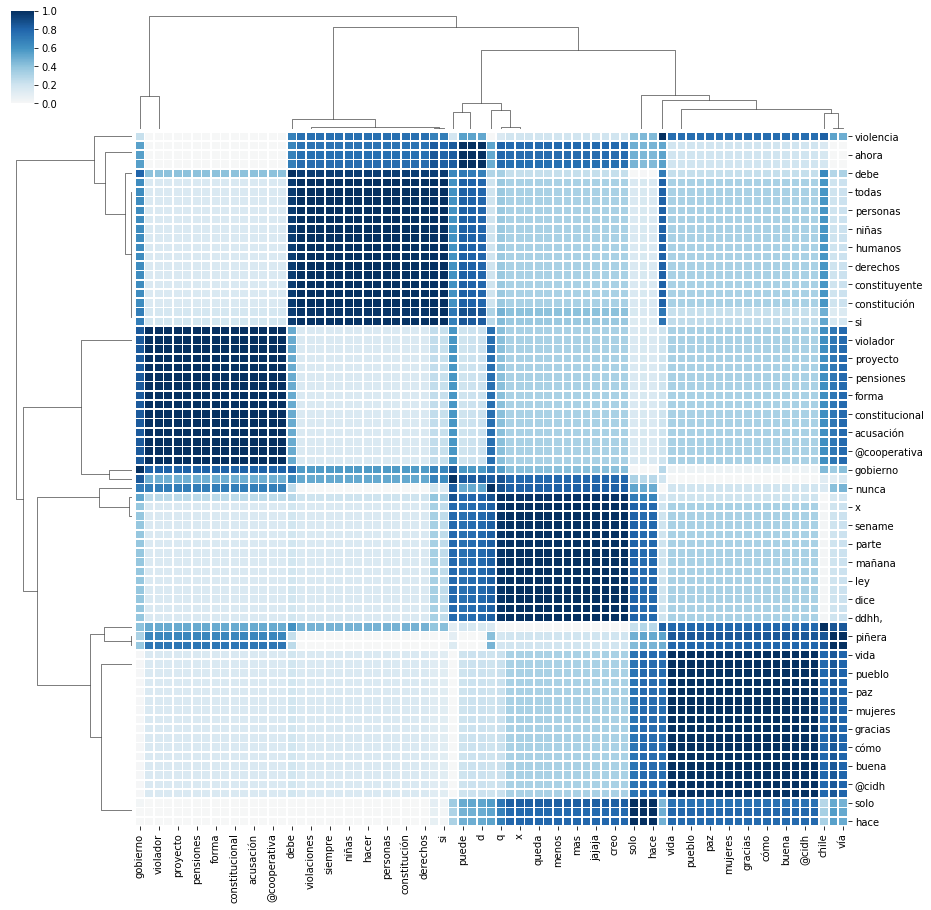

In [53]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

**Figure 4. Topic Analysis Heatmap** This plot lets us see how clusters in the data were formed by the LDA approach. The colors get darker if there's a strong relationship between items along the two axes.
<a id="sec3-1"></a>

In [54]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       46.452332 -212.462891       1        1  49.570049
1      130.574280 -342.558167       2        1  16.947027
2      260.682495 -258.455902       3        1  16.874678
3      176.560501 -128.360901       4        1  16.608248, topic_info=      Category        Freq            Term       Total  loglift  logprob
term                                                                    
199    Default  146.000000               q  146.000000  30.0000  30.0000
806    Default   37.000000        derechos   37.000000  29.0000  29.0000
202    Default   97.000000              si   97.000000  28.0000  28.0000
532    Default  154.000000         gracias  154.000000  27.0000  27.0000
9363   Default   28.000000     violaciones   28.000000  26.0000  26.0000
1102   Default   17.000000             nan   17.000000  25.0000  25.0000
1205   Default   29.000000         acuerdo   29.000000  24.0000  24.0000
862    Default   15.000000         humanos   15.000000  23.0000  23.0000
5457   Default   22.000000    constitución   22.000000  22.0000  22.0000
445    Default   42.000000               d   42.000000  21.0000  21.0000
472    Default   37.000000            debe   37.000000  20.0000  20.0000
225    Default   26.000000               x   26.000000  19.0000  19.0000
7190   Default   12.000000   constituyente   12.000000  18.0000  18.0000
7351   Default   31.000000           @cidh   31.000000  17.0000  17.0000
684    Default   11.000000          jajaja   11.000000  16.0000  16.0000
5443   Default   47.000000        dignidad   47.000000  15.0000  15.0000
1659   Default   21.000000        comisión   21.000000  14.0000  14.0000
606    Default   62.000000             ser   62.000000  13.0000  13.0000
941    Default   24.000000         siempre   24.000000  12.0000  12.0000
2648   Default   10.000000  constitucional   10.000000  11.0000  11.0000
1709   Default   25.000000            ddhh   25.000000  10.0000  10.0000
172    Default   58.000000             hoy   58.000000   9.0000   9.0000
17783  Default    9.000000        violador    9.000000   8.0000   8.0000
1025   Default   15.000000        proyecto   15.000000   7.0000   7.0000
431    Default   51.000000        gobierno   51.000000   6.0000   6.0000
501    Default   29.000000           parte   29.000000   5.0000   5.0000
736    Default   24.000000           nueva   24.000000   4.0000   4.0000
9213   Default   21.000000             bot   21.000000   3.0000   3.0000
841    Default    9.000000       pensiones    9.000000   2.0000   2.0000
3374   Default   12.000000           queda   12.000000   1.0000   1.0000
...        ...         ...             ...         ...      ...      ...
2331    Topic4    3.334380      convención    3.704631   1.6900  -7.0753
202     Topic4   45.174389              si   97.942329   1.0214  -4.4691
1057    Topic4    7.722016      importante   10.609884   1.4776  -6.2355
2365    Topic4    7.514506         proceso   10.323678   1.4777  -6.2628
472     Topic4   18.510160            debe   37.049881   1.1013  -5.3613
1709    Topic4   13.801139            ddhh   25.946461   1.1640  -5.6549
941     Topic4   13.114173         siempre   24.551378   1.1682  -5.7059
864     Topic4    8.635473           niñas   13.575723   1.3429  -6.1237
1203    Topic4    6.430801             sl2    9.183420   1.4390  -6.4185
736     Topic4   11.207990           nueva   24.093285   1.0300  -5.8630
606     Topic4   19.594021             ser   62.188938   0.6403  -5.3044
445     Topic4   15.328329               d   42.001434   0.7873  -5.5499
3510    Topic4    5.063317       impunidad    6.667912   1.5200  -6.6576
681     Topic4    7.448863           tener   14.728451   1.1136  -6.2715
2380    Topic4   10.647786     carabineros   31.691483   0.7046  -5.9143
62      Topic4    8.701563           hacer   20.993210   0.9146  -6.1161
480     Topic4    7.775446      

**Figure 5. Topic Analysis** This plot involves two subplots. On the left, we have our different topic clusters from above and a measure of how similar they are to one another (ie: how close). On the right, we have a plot that highlights the role of each term in any of the 4 clusters if you mouse over it. Together, they tell us about how clusters interact (ie: patterns like how they clearly took different points on the axes to tell us that the algorithm identified mostly distrinct clusters but also the most salient terms in each topic. Cluster 1) talks about a lot of 'nicer' words than the other 3 but is still quite mixed, 2) talks about the government and president, 3) focuses on less signficant supporting words, and 4) discusses human rights/violence/children.

<a id="sec3-2"></a>

## 4) Reflection
<a id="sec4"></a>
Overall, I enjoyed this project even though sometimes it was a little hard to understand all of the moving parts I'd have to put forward. I think the most challenging things for me were importing all the necessary packages related to the harder modeling that I wanted to do and finding a good way to access a sentiment analysis package that supports the spanish language. I also found it challenging to create some specific features like the hashtag distribution over days because it required some serious transformation of the data.

My steps were the following:
    1. Process the data and make a dataframe with relevant new variables
    2. Create exploratory visualizations to understand new things about the data
    3. Conduct a hypothesis test based on sentiment analysis of tweets by gender to see whether men or women tweet more positive content. 
       Answer: women
    4. Implement LDA topic modeling to examine natural clusters of topics in the data.
    
    
My analysis told me that topics that matter to these Chileans during the protests are the president, violence against children/women, human rights, and constitucional issues. Through my early visualization of hashtag popularity over time, you can see that they do indeed shift in popularity over time, perhaps as more and more conversations are taking place outside of Twitter or possibly in the event that there are some outside forces meddling in their communication. It would be interesting to do some investigation of this and of how both sides of the spectrum interact with each other going forward.